# Case Study #5: Data Mart
The case study questions presented here are created by [**Data With Danny**](https://linktr.ee/datawithdanny). They are part of the [**8 Week SQL Challenge**](https://8weeksqlchallenge.com/).

My SQL queries are written in the `PostgreSQL 15` dialect, integrated into `Jupyter Notebook`, which allows us to instantly view the query results and document the queries.

For more details about the **Case Study #5**, click [**here**](https://8weeksqlchallenge.com/case-study-5/).

## Table of Contents

### [1. Importing Libraries](#Import)

### [2. Tables of the Database](#Tables)

### [3. Case Study Questions](#CaseStudyQuestions)

- [A. Data Cleansing](#A)
- [B. Data Exploration](#B)
- [C. Before & After Analysis](#C)
- [D. Bonus Question](#D)

<a id = 'Import'></a>
## 1. Importing Required Libraries

In [1]:
import psycopg2 as pg2
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import warnings

warnings.filterwarnings('ignore')

### Connecting PostgreSQL database from Jupyter Notebook

In [2]:
# Get PostgreSQL password
mypassword = os.getenv('POSTGRESQL_PASSWORD')

# Connecting to database
conn = pg2.connect(user = 'postgres', password = mypassword, database = 'data_mart')
cursor = conn.cursor()

____
<a id = 'Tables'></a>
## 2. Tables of the Database

In [3]:
cursor.execute("""
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema = 'data_mart'
"""
)

print('--- Tables within "data_mart" database --- ')
for table in cursor:
    print(table[1])

--- Tables within "data_mart" database --- 
weekly_sales


Here is the `weekly_sales` table, containing 17,117 data since the March 26, 2018

In [4]:
pd.read_sql("""
SELECT *
FROM data_mart.weekly_sales;
""", conn)

,week_date,region,platform,segment,customer_type,transactions,sales
0,31/8/20,ASIA,Retail,C3,New,120631,3656163
1,31/8/20,ASIA,Retail,F1,New,31574,996575
2,31/8/20,USA,Retail,null,Guest,529151,16509610
3,31/8/20,EUROPE,Retail,C1,New,4517,141942
4,31/8/20,AFRICA,Retail,C2,New,58046,1758388
...,...,...,...,...,...,...,...
17112,26/3/18,AFRICA,Retail,C3,New,98342,3706066
17113,26/3/18,USA,Shopify,C4,New,16,2784
17114,26/3/18,USA,Retail,F2,New,25665,1064172
17115,26/3/18,EUROPE,Retail,C4,New,883,33523


___
<a id = 'CaseStudyQuestions'></a>
## 3. Case Study Questions

<a id='A'></a>
## A. Data Cleansing
In a single query, perform the following operations and generate a *new table* in the data_mart schema named `clean_weekly_sales`:

- Convert the `week_date` to a DATE format

- Add a `week_number` as the second column for each `week_date` value, for example any value from the 1st of January to 7th of January will be 1, 8th to 14th will be 2 etc

- Add a `month_number` with the calendar month for each `week_date` value as the 3rd column

- Add a `calendar_year` column as the 4th column containing either 2018, 2019 or 2020 values

- Add a new column called `age_band` after the original `segment` column using the following mapping on the number inside the segment value

segment | age_band 
 --- | --- 
1 | Young Adults
2 | Middle Aged
3 or 4 | Retirees

- Add a new `demographic` column using the following mapping for the first letter in the segment values:

segment	| demographic
 --- | --- 
C | Couples
F | Families

- Ensure all null string values with an "unknown" string value in the original `segment` column as well as the new `age_band` and `demographic` columns

- Generate a new `avg_transaction` column as the sales value divided by transactions rounded to 2 decimal places for each record

___
Creating an empty table is the initial step required to store the processed data from the original dataset `weekly_sales` in the desired column order. By using a single query with the `INSERT INTO` statement, it is possible to execute various data cleaning steps within the `SELECT` block.

In [5]:
# Creating table
cursor.execute("DROP TABLE IF EXISTS data_mart.clean_weekly_sales;")
cursor.execute("""
CREATE TABLE data_mart.clean_weekly_sales
(
    "week_date" DATE,
    "week_number" INTEGER,
    "month_number" INTEGER,
    "calendar_year" INTEGER,
    "region" VARCHAR(13),
    "platform" VARCHAR(7),
    "segment" VARCHAR(10),
    "age_band" VARCHAR(50),
    "demographic" VARCHAR(10),
    "customer_type" VARCHAR(8),
    "transactions" INTEGER,
    "sales" INTEGER,
    "avg_transaction" DECIMAL
);
""")


# Inserting required and processed data into the newly created table
cursor.execute("""
INSERT INTO data_mart.clean_weekly_sales
SELECT 
    TO_DATE(week_date, 'dd/mm/yy') AS week_date,
    DATE_PART('week', TO_DATE(week_date, 'dd/mm/yy'))::INTEGER as week_number,
    DATE_PART('month', TO_DATE(week_date, 'dd/mm/yy'))::INTEGER as month_number,
    DATE_PART('year', TO_DATE(week_date, 'dd/mm/yy'))::INTEGER as calendar_year,
    region,
    platform,
    CASE WHEN segment = 'null' THEN 'unknown' ELSE segment END as segment,
    CASE 
        WHEN segment LIKE '%1' THEN 'Young Adults' 
        WHEN segment LIKE '%2' THEN 'Middle Aged'
        WHEN REGEXP_LIKE(segment, '3|4') THEN 'Retirees'
        ELSE 'unknown'
    END AS age_band,
    
    CASE 
        WHEN segment LIKE 'C%' THEN 'Couples'
        WHEN segment LIKE 'F%' THEN 'Families'
        ELSE 'unknown' 
    END AS demographic,
    customer_type,
    transactions,
    sales,
    ROUND(sales/transactions::numeric, 2) AS avg_transaction
FROM data_mart.weekly_sales;
""")

# Saving updates
conn.commit()

**Result**

In [6]:
pd.read_sql("""
SELECT * 
FROM data_mart.clean_weekly_sales;
""", conn)

,week_date,week_number,month_number,calendar_year,region,platform,segment,age_band,demographic,customer_type,transactions,sales,avg_transaction
0,2020-08-31,36,8,2020,ASIA,Retail,C3,Retirees,Couples,New,120631,3656163,30.31
1,2020-08-31,36,8,2020,ASIA,Retail,F1,Young Adults,Families,New,31574,996575,31.56
2,2020-08-31,36,8,2020,USA,Retail,unknown,unknown,unknown,Guest,529151,16509610,31.20
3,2020-08-31,36,8,2020,EUROPE,Retail,C1,Young Adults,Couples,New,4517,141942,31.42
4,2020-08-31,36,8,2020,AFRICA,Retail,C2,Middle Aged,Couples,New,58046,1758388,30.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17112,2018-03-26,13,3,2018,AFRICA,Retail,C3,Retirees,Couples,New,98342,3706066,37.69
17113,2018-03-26,13,3,2018,USA,Shopify,C4,Retirees,Couples,New,16,2784,174.00
17114,2018-03-26,13,3,2018,USA,Retail,F2,Middle Aged,Families,New,25665,1064172,41.46
17115,2018-03-26,13,3,2018,EUROPE,Retail,C4,Retirees,Couples,New,883,33523,37.96


___
<a id = 'B'></a>
## B. Data Exploration

#### 1. What day of the week is used for each `week_date` value?

In [7]:
pd.read_sql("""
SELECT DISTINCT TO_CHAR(week_date, 'Day') AS day_of_week
FROM data_mart.clean_weekly_sales;
""", conn)

,day_of_week
0,Monday


**Result**\
Monday is the designated day of the week for each `week_date` value.

___
#### 2. What range of week numbers are missing from the dataset?

Taking into consideration that there are 52 weeks in a year, we can utilize the `generate_series` function to generate a series of numbers from 1 to 52. By performing a **LEFT JOIN** between this number series and the `clean_week_sales` table, we can identify all the week numbers that are not present in the dataset.

In [8]:
pd.read_sql("""
SELECT gs.week_number AS missing_week_nb
FROM generate_series(1,52,1) gs(week_number)
LEFT JOIN data_mart.clean_weekly_sales d ON gs.week_number = d.week_number
WHERE d.week_number IS NULL
""", conn)

,missing_week_nb
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


**Result**
- The first range of missing week numbers in the dataset is from week 1 to week 12.
- The second missing range of week numbers is from week 37 to week 52.

___
#### 3. How many total transactions were there for each year in the dataset?

In [9]:
pd.read_sql("""
SELECT 
    calendar_year AS year, 
    COUNT(transactions) AS nb_transactions
FROM data_mart.clean_weekly_sales
GROUP BY year;
""", conn)

,year,nb_transactions
0,2018,5698
1,2020,5711
2,2019,5708


___
#### 4. What is the total sales for each region for each month?

In [10]:
df4 = pd.read_sql("""
SELECT 
    region, 
    calendar_year AS year,
    TO_CHAR(week_date, 'Month') AS month_name,
    SUM(sales) AS total_sales
FROM data_mart.clean_weekly_sales
GROUP BY region, year, month_number, month_name
ORDER BY region, year, month_number
""", conn)

df4

,region,year,month_name,total_sales
0,AFRICA,2018,March,130542213
1,AFRICA,2018,April,650194751
2,AFRICA,2018,May,522814997
3,AFRICA,2018,June,519127094
4,AFRICA,2018,July,674135866
...,...,...,...,...
135,USA,2020,April,221952003
136,USA,2020,May,225545881
137,USA,2020,June,277763625
138,USA,2020,July,223735311


**Result**\
The output table above, containing 140 rows, makes it challenging to gain insights into the sales performance at Data Mart. Therefore, let's examine a time-series visualization that represents the total sales made by Data Mart by region, using the `hue` parameter.

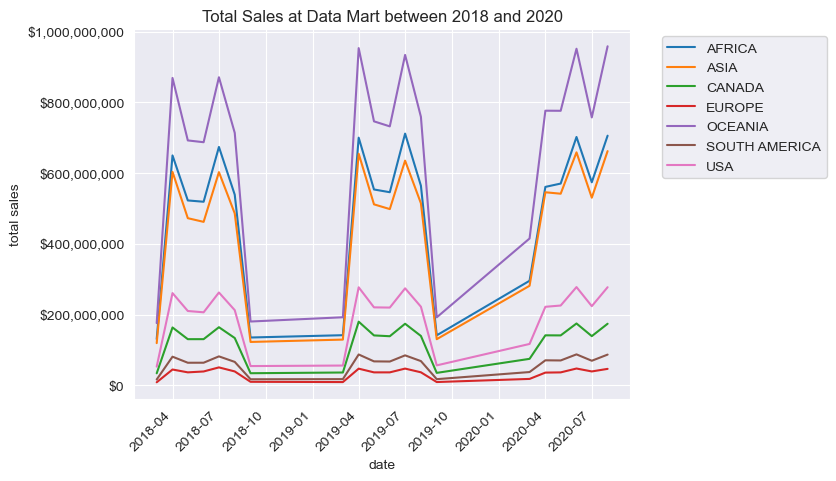

In [11]:
# Insert a new column for datetime using calendar_year and month_name values 
df4['date'] = df4.apply(lambda row: datetime(row['year'], datetime.strptime(row['month_name'].strip(), '%B').month, 1), axis=1)


# plot the total_sales by region
sns.set_style("darkgrid")
sns.lineplot(df4['date'], df4['total_sales'], hue = df4['region'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# customize the format, labels and title
plt.xticks(rotation=45, ha='right')
plt.ylabel("total sales")
formatter = ticker.StrMethodFormatter('${x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Total Sales at Data Mart between 2018 and 2020');

**Insights**
- Data Mart has achieved the highest sales in Oceania since 2018.
- Following Oceania, Africa and Asia are the second and third most lucrative regions for Data Mart sales.
- South America and Europe recorded the lowest sales figures from 2018 to 2020.

___
#### 5. What is the total count of transactions for each platform

In [12]:
pd.read_sql("""
SELECT 
    platform, 
    COUNT(transactions) AS nb_transactions
FROM data_mart.clean_weekly_sales
GROUP BY platform;
""", conn)

,platform,nb_transactions
0,Shopify,8549
1,Retail,8568


___
#### 6. What is the percentage of sales for Retail vs Shopify for each month?

In [13]:
pd.read_sql("""
WITH platform_sales_cte AS
(
    SELECT 
        calendar_year, 
        month_number,
        TO_CHAR(week_date, 'Month') AS month,
        SUM(sales) AS monthly_sales,
        SUM(CASE WHEN platform = 'Retail' THEN sales ELSE 0 END) AS retail_sales,
        SUM(CASE WHEN platform = 'Shopify' THEN sales ELSE 0 END) AS shopify_sales
    FROM data_mart.clean_weekly_sales
    GROUP BY calendar_year, month_number, month
    ORDER BY calendar_year, month
)
SELECT 
    calendar_year AS year, 
    month, 
    ROUND(retail_sales/monthly_sales::numeric*100,1) AS retail_percent_sales,
    ROUND(shopify_sales/monthly_sales::numeric*100,1) AS shopify_percent_sales
FROM platform_sales_cte;
""", conn)

,year,month,retail_percent_sales,shopify_percent_sales
0,2018,April,97.9,2.1
1,2018,August,97.7,2.3
2,2018,July,97.8,2.2
3,2018,June,97.8,2.2
4,2018,March,97.9,2.1
5,2018,May,97.7,2.3
6,2018,September,97.7,2.3
7,2019,April,97.8,2.2
8,2019,August,97.2,2.8
9,2019,July,97.4,2.6


**Result**\
Retail has achieved significantly higher sales, accounting for approximately 97% of the total sales, while Shopify only accounted for 2.5% of the sales.

___
#### 7. What is the percentage of sales by demographic for each year in the dataset?

In [14]:
pd.read_sql("""
WITH demographic_sales_cte AS
(
    SELECT 
        calendar_year AS year,
        SUM(sales) AS total_sales,
        SUM(CASE WHEN demographic = 'Families' THEN sales END) AS families_sales,
        SUM(CASE WHEN demographic = 'Couples' THEN sales END) AS couples_sales,
        SUM(CASE WHEN demographic = 'unknown' THEN sales END) AS unknown_sales
    FROM data_mart.clean_weekly_sales
    GROUP BY year
)
SELECT 
    year, 
    ROUND(families_sales/total_sales::numeric*100,1) AS families_sales_percent,
    ROUND(couples_sales/total_sales::numeric*100,1) AS couples_sales_percent,
    ROUND(unknown_sales/total_sales::numeric*100,1) AS unknown_sales_percent
FROM demographic_sales_cte;
""", conn)

,year,families_sales_percent,couples_sales_percent,unknown_sales_percent
0,2018,32.0,26.4,41.6
1,2020,32.7,28.7,38.6
2,2019,32.5,27.3,40.3


**Result**\
Families contributed slightly more to the sales of Data Mart, accounting for approximately 5% more sales compared to Couples.

___
#### 8. Which `age_band` and `demographic` values contribute the most to Retail sales?

In [15]:
query8 = """
SELECT 
    age_band, 
    demographic, 
    ROUND(SUM(sales)/(SELECT SUM(sales) FROM data_mart.clean_weekly_sales WHERE platform = 'Retail')::NUMERIC * 100,1) AS contribution_percent
FROM data_mart.clean_weekly_sales
WHERE platform = 'Retail'
GROUP BY age_band, demographic
ORDER BY contribution_percent DESC
"""

pd.read_sql(query8, conn)

,age_band,demographic,contribution_percent
0,unknown,unknown,40.5
1,Retirees,Families,16.7
2,Retirees,Couples,16.1
3,Middle Aged,Families,11.0
4,Young Adults,Couples,6.6
5,Middle Aged,Couples,4.7
6,Young Adults,Families,4.5


Alternatively, let's extract the values with the highest contribution percent.

In [16]:
pd.read_sql(query8 + "LIMIT 2", conn)

,age_band,demographic,contribution_percent
0,unknown,unknown,40.5
1,Retirees,Families,16.7


**Result**\
Retired Families are the age_band and demographic values that contributed the most to the Retail sales.

___
#### 9. Can we use the `avg_transaction` column to find the average transaction size for each year for Retail vs Shopify? If not - how would you calculate it instead?

**Method 1:** When using `GROUP BY` to calculate the average transaction size for each year, the obtained results differ slightly from using the `avg_transaction` column directly.

In [17]:
pd.read_sql("""
SELECT 
    calendar_year AS year, 
    platform,
    ROUND(AVG(avg_transaction),2) AS avg_transaction1,
    ROUND(SUM(sales)::NUMERIC/SUM(transactions)::NUMERIC,2) AS avg_transaction2
FROM data_mart.clean_weekly_sales
GROUP BY year, platform
ORDER BY platform, year
""", conn)

,year,platform,avg_transaction1,avg_transaction2
0,2018,Retail,42.91,36.56
1,2019,Retail,41.97,36.83
2,2020,Retail,40.64,36.56
3,2018,Shopify,188.28,192.48
4,2019,Shopify,177.56,183.36
5,2020,Shopify,174.87,179.03


**Method #2:** With this following method, we obtain the same results as using the `avg_transactions` values.

In [18]:
pd.read_sql("""
SELECT 
    calendar_year AS year,
    ROUND(AVG(CASE WHEN platform = 'Retail' THEN avg_transaction END),2) AS retail_avg_txn1,
    ROUND(AVG(CASE WHEN platform = 'Retail' THEN sales::numeric/transactions::numeric END),2) AS retail_avg_txn2,
    ROUND(AVG(CASE WHEN platform = 'Shopify' THEN avg_transaction END),2) AS shopify_avg_txn1,
    ROUND(AVG(CASE WHEN platform = 'Shopify' THEN sales::numeric/transactions::numeric END),2) AS shopify_avg_txn2
FROM data_mart.clean_weekly_sales
GROUP BY year
""", conn)

,year,retail_avg_txn1,retail_avg_txn2,shopify_avg_txn1,shopify_avg_txn2
0,2018,42.91,42.91,188.28,188.28
1,2020,40.64,40.64,174.87,174.87
2,2019,41.97,41.97,177.56,177.56


___
<a id = 'C'></a>
## C. Before & After Analysis
This technique is usually used when we inspect an important event and want to inspect the impact before and after a certain point in time.

Taking the `week_date` value of **2020-06-15** as the baseline week where the Data Mart sustainable packaging changes came into effect.

We would include all `week_date` values for **2020-06-15** as the start of the period after the change and the previous `week_date` values would be before

Using this analysis approach - answer the following questions:

> 1. What is the total sales for the 4 weeks before and after 2020-06-15? What is the growth or reduction rate in actual values and percentage of sales?
> 2. What about the entire 12 weeks before and after?
> 3. How do the sale metrics for these 2 periods before and after compare with the previous years in 2018 and 2019?

#### 1. What is the total sales for the 4 weeks before and after 2020-06-15? What is the growth or reduction rate in actual values and percentage of sales?

The week number of the date **2020-06-15** is 25. Therefore, 
- the four weeks before this date are `week 21, 22, 23, and 24`, and 
- the four weeks after are `week 25, 26, 27, and 28`.

In [19]:
pd.read_sql("""
SELECT DISTINCT week_number
FROM data_mart.clean_weekly_sales
WHERE week_date = '2020-06-15'
""", conn)

,week_number
0,25


**Result**\
The implementation of sustainable packaging changes appears to have a **negative impact** on sales at Data Mart, resulting in a reduction rate of 1.15% in sales.

In [20]:
pd.read_sql("""
SELECT 
    TO_CHAR(total_sales_before, 'FM$ 999,999,999,999') AS total_sales_before,
    TO_CHAR(total_sales_after, 'FM$ 999,999,999,999') AS total_sales_after,
    TO_CHAR(total_sales_after - total_sales_before, 'FM$ 999,999,999,999') AS difference,
    ROUND((total_sales_after - total_sales_before)/total_sales_before::NUMERIC * 100,2) AS sales_change_percent
FROM
(
    SELECT
        SUM(CASE WHEN week_number BETWEEN 21 AND 24 THEN sales ELSE 0 END) AS total_sales_before,
        SUM(CASE WHEN week_number BETWEEN 25 AND 28 THEN sales ELSE 0 END) AS total_sales_after
    FROM data_mart.clean_weekly_sales
    WHERE calendar_year = 2020
) sales;
""", conn)

,total_sales_before,total_sales_after,difference,sales_change_percent
0,"$ 2,345,878,357","$ 2,318,994,169","$ -26,884,188",-1.15


___
#### 2. What about the entire 12 weeks before and after?

In [21]:
pd.read_sql("""
SELECT 
    TO_CHAR(total_sales_before, 'FM$ 999,999,999,999') AS total_sales_before,
    TO_CHAR(total_sales_after, 'FM$ 999,999,999,999') AS total_sales_after,
    TO_CHAR(total_sales_after - total_sales_before, 'FM$ 999,999,999,999') AS difference,
    ROUND((total_sales_after - total_sales_before)/total_sales_before::NUMERIC * 100, 2) AS sales_change_percent
FROM
(
    SELECT 
        SUM(CASE WHEN week_number BETWEEN 13 AND 24 THEN sales ELSE 0 END) AS total_sales_before,
        SUM(CASE WHEN week_number BETWEEN 25 AND 37 THEN sales ELSE 0 END) AS total_sales_after
    FROM data_mart.clean_weekly_sales
    WHERE calendar_year = 2020
) sales
""", conn)

,total_sales_before,total_sales_after,difference,sales_change_percent
0,"$ 7,126,273,147","$ 6,973,947,753","$ -152,325,394",-2.14


**Result**\
The implementation of sustainable packaging changes appears to have a **negative impact** on sales at Data Mart, resulting in a reduction rate of 2.14% in sales.

___
#### 3. How do the sale metrics for these 2 periods before and after compare with the previous years in 2018 and 2019?

In [22]:
pd.read_sql("""
SELECT 
    year,
    TO_CHAR(total_sales_before, 'FM$ 999,999,999,999') AS total_sales_before,
    TO_CHAR(total_sales_after, 'FM$ 999,999,999,999') AS total_sales_after,
    TO_CHAR(total_sales_after - total_sales_before, 'FM$ 999,999,999,999') AS difference,
    ROUND((total_sales_after - total_sales_before)/total_sales_before::NUMERIC * 100, 2) AS sales_change_percent
FROM
(
    SELECT 
        calendar_year AS year,
        SUM(CASE WHEN week_number BETWEEN 13 AND 24 THEN sales ELSE 0 END) AS total_sales_before,
        SUM(CASE WHEN week_number BETWEEN 25 AND 37 THEN sales ELSE 0 END) AS total_sales_after
    FROM data_mart.clean_weekly_sales
    GROUP BY year
) sales
ORDER BY year
""", conn)

,year,total_sales_before,total_sales_after,difference,sales_change_percent
0,2018,"$ 6,396,562,317","$ 6,500,818,510","$ 104,256,193",1.63
1,2019,"$ 6,883,386,397","$ 6,862,646,103","$ -20,740,294",-0.30
2,2020,"$ 7,126,273,147","$ 6,973,947,753","$ -152,325,394",-2.14


___
<a id = 'D'></a>
## D. Bonus Question
Which areas of the business have the highest negative impact in sales metrics performance in 2020 for the 12 week before and after period?

- region
- platform
- age_band
- demographic
- customer_type

Do you have any further recommendations for Danny’s team at Data Mart or any interesting insights based off this analysis?

### Overview
The following query output displays the various areas of the business that experienced the highest negative impact on sales metrics performance in 2020. By setting `WHERE sales_before > sales_after`, only the negative percent changes record will be filtered and displayed (the top 10 records).

In [23]:
pd.read_sql("""
WITH overview_sales_cte AS
(
    SELECT 
        region, 
        platform, 
        age_band, 
        demographic, 
        customer_type, 
        SUM(CASE WHEN week_number BETWEEN 13 AND 24 THEN sales ELSE 0 END) AS sales_before,
        SUM(CASE WHEN week_number BETWEEN 25 AND 37 THEN sales ELSE 0 END) AS sales_after
    FROM data_mart.clean_weekly_sales
    WHERE calendar_year = 2020
    GROUP BY region, platform, age_band, demographic, customer_type
)
SELECT 
    region, 
    platform, 
    age_band, 
    demographic, 
    customer_type,
    ROUND((sales_after - sales_before)::NUMERIC/sales_before::NUMERIC * 100, 2) AS sales_change_percent
FROM overview_sales_cte
WHERE sales_before > sales_after     
ORDER BY sales_change_percent ASC
LIMIT 10;            
""", conn)

,region,platform,age_band,demographic,customer_type,sales_change_percent
0,SOUTH AMERICA,Shopify,unknown,unknown,Existing,-42.23
1,EUROPE,Shopify,Retirees,Families,New,-33.71
2,EUROPE,Shopify,Young Adults,Families,New,-27.97
3,SOUTH AMERICA,Retail,unknown,unknown,Existing,-23.20
4,SOUTH AMERICA,Retail,Retirees,Families,New,-21.28
5,SOUTH AMERICA,Shopify,Middle Aged,Families,New,-19.73
6,SOUTH AMERICA,Shopify,Retirees,Families,New,-19.04
7,SOUTH AMERICA,Shopify,Retirees,Couples,New,-18.39
8,SOUTH AMERICA,Retail,Retirees,Couples,Existing,-16.80
9,SOUTH AMERICA,Retail,Retirees,Couples,New,-15.86


___
In the followings, I will analyze each area individually to determine which category has been the most impacted.

### Sales By Region
The **Asia** region has been the most negatively impacted by the implementation of the new system at Data Mart.

In [24]:
pd.read_sql("""
WITH region_sales_cte AS
(
    SELECT 
        region, 
        SUM(CASE WHEN week_number BETWEEN 13 AND 24 THEN sales END) AS sales_before,
        SUM(CASE WHEN week_number BETWEEN 25 AND 37 THEN sales END) AS sales_after
    FROM data_mart.clean_weekly_sales
    WHERE calendar_year = 2020
    GROUP BY region
) 
SELECT 
    region, 
    ROUND((sales_after - sales_before)/sales_before::NUMERIC * 100,2) AS sales_change_percent
FROM region_sales_cte
ORDER BY sales_change_percent ASC;
""", conn)

,region,sales_change_percent
0,ASIA,-3.26
1,OCEANIA,-3.03
2,SOUTH AMERICA,-2.15
3,CANADA,-1.92
4,USA,-1.60
5,AFRICA,-0.54
6,EUROPE,4.73


### Sales By Platform

The **Retail** platform has been the most negatively impacted by the implementation of the new system at Data Mart.

In [25]:
pd.read_sql("""
WITH platform_sales_cte AS
(
    SELECT 
        platform, 
        SUM(CASE WHEN week_number BETWEEN 13 AND 24 THEN sales END) AS sales_before,
        SUM(CASE WHEN week_number BETWEEN 25 AND 37 THEN sales END) AS sales_after
    FROM data_mart.clean_weekly_sales
    WHERE calendar_year = 2020
    GROUP BY platform
) 
SELECT 
    platform, 
    ROUND((sales_after - sales_before)/sales_before::NUMERIC * 100,2) AS sales_change_percent
FROM platform_sales_cte
ORDER BY sales_change_percent ASC;
""", conn)

,platform,sales_change_percent
0,Retail,-2.43
1,Shopify,7.18


### Sales By Age_Band
The **Middle Aged** customers have been the most negatively impacted by the implementation of the new system at Data Mart.

In [26]:
pd.read_sql("""
WITH age_band_sales_cte AS
(
    SELECT 
        age_band, 
        SUM(CASE WHEN week_number BETWEEN 13 AND 24 THEN sales END) AS sales_before,
        SUM(CASE WHEN week_number BETWEEN 25 AND 37 THEN sales END) AS sales_after
    FROM data_mart.clean_weekly_sales
    WHERE calendar_year = 2020
    GROUP BY age_band
) 
SELECT 
    age_band, 
    ROUND((sales_after - sales_before)/sales_before::NUMERIC * 100,2) AS sales_change_percent
FROM age_band_sales_cte
ORDER BY sales_change_percent ASC;
""", conn)

,age_band,sales_change_percent
0,unknown,-3.34
1,Middle Aged,-1.97
2,Retirees,-1.23
3,Young Adults,-0.92


### Sales By Demographic
The **Families** demographic category has been the most negatively impacted by the implementation of the new system at Data Mart.

In [27]:
pd.read_sql("""
WITH demographic_sales_cte AS
(
    SELECT 
        demographic, 
        SUM(CASE WHEN week_number BETWEEN 13 AND 24 THEN sales END) AS sales_before,
        SUM(CASE WHEN week_number BETWEEN 25 AND 37 THEN sales END) AS sales_after
    FROM data_mart.clean_weekly_sales
    WHERE calendar_year = 2020
    GROUP BY demographic
) 
SELECT 
    demographic, 
    ROUND((sales_after - sales_before)/sales_before::NUMERIC * 100,2) AS sales_change_percent
FROM demographic_sales_cte
ORDER BY sales_change_percent ASC;
""", conn)

,demographic,sales_change_percent
0,unknown,-3.34
1,Families,-1.82
2,Couples,-0.87


### Sales By Customer_Type

The **Guest** customer type has been the most negatively impacted by the implementation of the new system at Data Mart.

In [28]:
pd.read_sql("""
WITH customer_type_sales_cte AS
(
    SELECT 
        customer_type, 
        SUM(CASE WHEN week_number BETWEEN 13 AND 24 THEN sales END) AS sales_before,
        SUM(CASE WHEN week_number BETWEEN 25 AND 37 THEN sales END) AS sales_after
    FROM data_mart.clean_weekly_sales
    WHERE calendar_year = 2020
    GROUP BY customer_type
) 
SELECT 
    customer_type, 
    ROUND((sales_after - sales_before)/sales_before::NUMERIC * 100,2) AS sales_change_percent
FROM customer_type_sales_cte
ORDER BY sales_change_percent ASC;
""", conn)

,customer_type,sales_change_percent
0,Guest,-3.00
1,Existing,-2.27
2,New,1.01


In [29]:
conn.close()